In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/uonat/SS2023_DI-Lab_Precitaste.git

In [ ]:
%cd SS2023_DI-Lab_Precitaste

In [ ]:
#!git checkout remotes/origin/CLIP-implementation

In [7]:
%pip install . &> /dev/null

In [8]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Object Proposer

In [9]:
import distutils.core
import sys,os
!git clone 'https://github.com/facebookresearch/detectron2'  &> /dev/null
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} &> /dev/null
sys.path.insert(0, os.path.abspath('./detectron2'))

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [10]:
!python -m pip install timm &> /dev/null

In [11]:
from models.VitDet import load_model as load_VitDet,Draw_pred_BB,Draw_original_seg
model_path ="/content/drive/MyDrive/ApplicationProject/Models/model2.pkl"
config_path = "/content/SS2023_DI-Lab_Precitaste/detectron2/projects/ViTDet/configs/LVIS/mask_rcnn_vitdet_h_100ep.py"
vitDet_model = load_VitDet(model_path,config_path) 

[05/23 12:54:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ApplicationProject/Models/model2.pkl ...


# An image sample

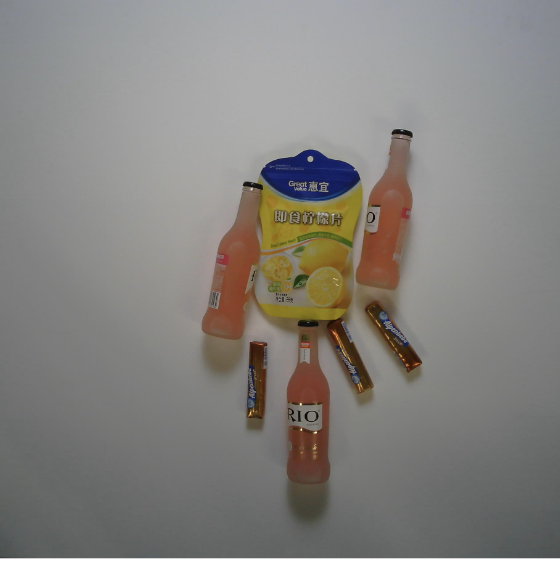

In [13]:
from PIL import Image
Image.open("sample.png").convert("RGB")

In [15]:
from torchvision import transforms
img = transforms.PILToTensor()(Image.open("sample.png").convert("RGB"))
#Image.open("CLIP.png").convert("RGB")

## Get Obj proposels

In [16]:
batch = [{'image':img.to(device)}]

vitDet_model.to(device)
vitDet_model.eval()
with torch.no_grad():
  model_result=vitDet_model(batch)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


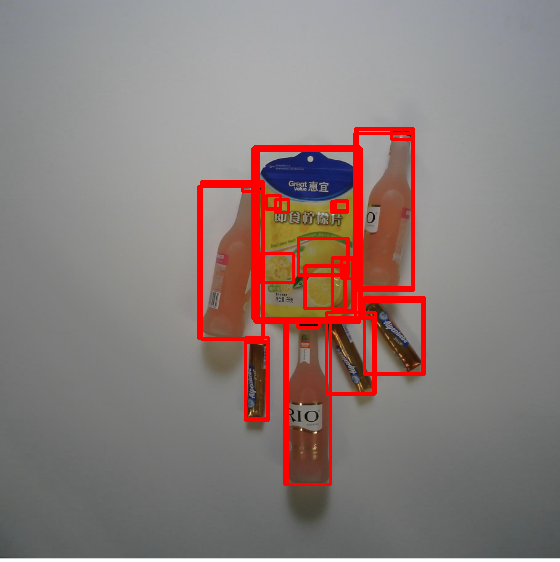

In [17]:
import numpy as np
Draw_pred_BB(np.asarray(img.movedim(0,-1))[:, :, ::-1],model_result)

## Remove overlapping Bounding boxes

In [19]:
from utilities.non_maximum_suppression import run_nms 

picked_boxes, picked_score = run_nms(
    model_result[0]['instances'].pred_boxes.tensor.to(torch.int).tolist(),
    model_result[0]['instances'].scores.tolist(),
    np.asarray(img),
    0.2
)

## Crop Obj proposels

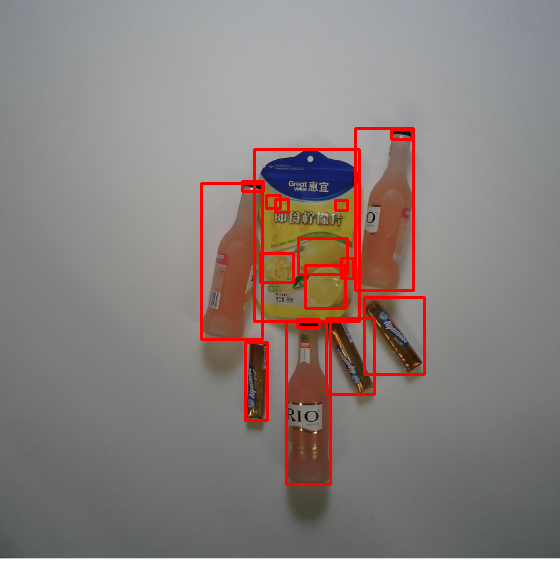

In [20]:
import cv2, numpy as np
from google.colab.patches import cv2_imshow

def Draw_pred_BB_editted(img,p_b,p_s):
  final_img = img.copy()
  for row_index in range(len(p_b)):
    if p_s[row_index] > 0.5:
      x1,y1,x2,y2 = p_b[row_index]
      cv2.rectangle(final_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
  cv2_imshow(final_img)

Draw_pred_BB_editted(np.asarray(img.movedim(0,-1))[:, :, ::-1],picked_boxes,picked_score)

In [21]:
cropped_images = []
for i in  picked_boxes:
  x1,y1,x2,y2 = i
  #cv2_imshow( np.asarray(img.movedim(0,-1))[y1:y2,x1:x2, ::-1])
  cropped_images.append(np.asarray(img.movedim(0,-1))[y1:y2,x1:x2, ::-1])

## Apply CLIP on  cropped images

In [22]:
%pip install ftfy regex tqdm &> /dev/null
%pip install git+https://github.com/openai/CLIP.git &> /dev/null

from models.CLIP import available_clip_models,load_model as load_clip,tokenize_text
#available_clip_models()
clip_model, preprocess = load_clip("ViT-B/32",device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 76.0MiB/s]


In [67]:
input_text = "a photo of {}".format("lemons")#"a chocolate bar","an orange drink","a soda","a lemonjuice"
text_p = tokenize_text(input_text,device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_p)
text_features /= text_features.norm(dim=-1, keepdim=True)

#TODO all images at once in a batch
similarities = []
for cropped_image in cropped_images:
  img_p = preprocess(Image.fromarray(np.uint8(cropped_image.copy()))).unsqueeze(0).to(device)
  with torch.no_grad():
    image_features = clip_model.encode_image(img_p)
    image_features /= image_features.norm(dim=-1, keepdim=True)
  similarities.append(image_features @ text_features.T)

In [68]:
#threshhold if more than this, object detected 

<ipython-input-69-8902ca98e606>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  for ind,matched in enumerate(np.asarray(similarities)>0.245):
<ipython-input-69-8902ca98e606>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for ind,matched in enumerate(np.asarray(similarities)>0.245):


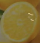

In [69]:
for ind,matched in enumerate(np.asarray(similarities)>0.245):
  if matched:
    cv2_imshow(cropped_images[ind])

## TODO classification

In [ ]:
"""

for i in cropped_images:
  image = preprocess(Image.fromarray(np.uint8(i.copy()))).unsqueeze(0).to(device)
  Label_names = ["an orange soda bottle", "a chocolate bar", "a bottle cap","a lemon"]
  text = clip.tokenize(Label_names).to(device)


  with torch.no_grad():
      image_features = model_clip.encode_image(image)
      text_features = model_clip.encode_text(text)
      
      logits_per_image, logits_per_text = model_clip(image, text)
      probs = logits_per_image.softmax(dim=-1).cpu().numpy()
      ## OR ##
      # Pick the top 5 most similar labels for the image
      #image_features /= image_features.norm(dim=-1, keepdim=True)
      #text_features /= text_features.norm(dim=-1, keepdim=True)
      #similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
      #values, indices = similarity[0].topk(5)
  #print("\nTop predictions:\n")
  #for value, index in zip(values, indices):
    #print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


  print ("Label names:",Label_names)
  print("Label probs:", probs[0])
  cv2_imshow(i)
"""